## Partially Linear Neural Network

We may structure Neural Network to have partially linear form. In this way, we do not need to do a two-step estimation.

In [1]:
# Import data
import numpy as np
import pandas as pd
from functions import *
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm 
import sqlite3
import os
import random
import tensorflow as tf


X_used, Y = get_data(42)
n = X_used.shape[0]

grid_size = 50
a_grid = np.linspace(np.min(X_used.age), np.max(X_used.age), grid_size)
w_grid = np.linspace(np.min(X_used.hh_inc), np.max(X_used.hh_inc), grid_size)
xv, wv = np.meshgrid(a_grid, w_grid, indexing='ij')

X_used_cnst = sm.add_constant(X_used)
model = sm.OLS(Y,X_used_cnst)
results = model.fit()
# results.summary()

In [2]:
characteristic_names = ['zerotofive','sixtotwenty','grp','home_own','gender','isHHH',
                        'live_together','work','get_social_benefit',
                        'got_social_benefit','religion','marriage','health',
                        'exercise','smoke','alcohol']

ATE_names = ['zerotofive','sixtotwenty','grp','home_own','gender','isHHH',
                        'live_together','work','get_social_benefit',
                        'got_social_benefit','religion','marriage','health',
                        'exercise','smoke','alcohol']

plot_names = ['Baby - No Baby', 'Teenager - No Teenager', 'Grandparents - No Grandparents','Homeowner - Lease',
              'Female - Male', 'Head - Not Head', 'Live Together - Separate', 
              'Work - No Work','Receive Social Insurance - Has Never Received', 'Had Received Social Insurance - Has Never Received',
              'Religion - No Religion','Married - Not Married', 'Health',
              'Exercise', 'Smoke - No Smoke', 'Alcohol - No Alcohol']

# characteristic_names = ['zerotofive','gender','live_together','marriage','health',
#                         'exercise','smoke','alcohol']
# ATE_names = characteristic_names
# plot_names = ['Baby - No Baby', 'Female - Male', 'Live Together - Separate', 'Married - Not Married', 'Very Healty (5) - Very Unhealty (1)','Very Healty (5) - Healty (4)',
#               'Exercise regularly - No Exercise', 'Smoke - No Smoke', 'Alcohol - No Alcohol']
n_jobs = 10
seed = 42
CV_grid_n = 10

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ nonlinear (InputLayer)        │ (None, 22)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 40)                │             920 │ nonlinear[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 20)                │             820 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ linear (InputLayer)           │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 10)                │             210 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 11)                │               0 │ linear[0][0],              │
│                               │                           │                 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │              12 │ concatenate[0][0]          │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,962 (7.66 KB)

 Trainable params: 1,962 (7.66 KB)

 Non-trainable params: 0 (0.00 B)

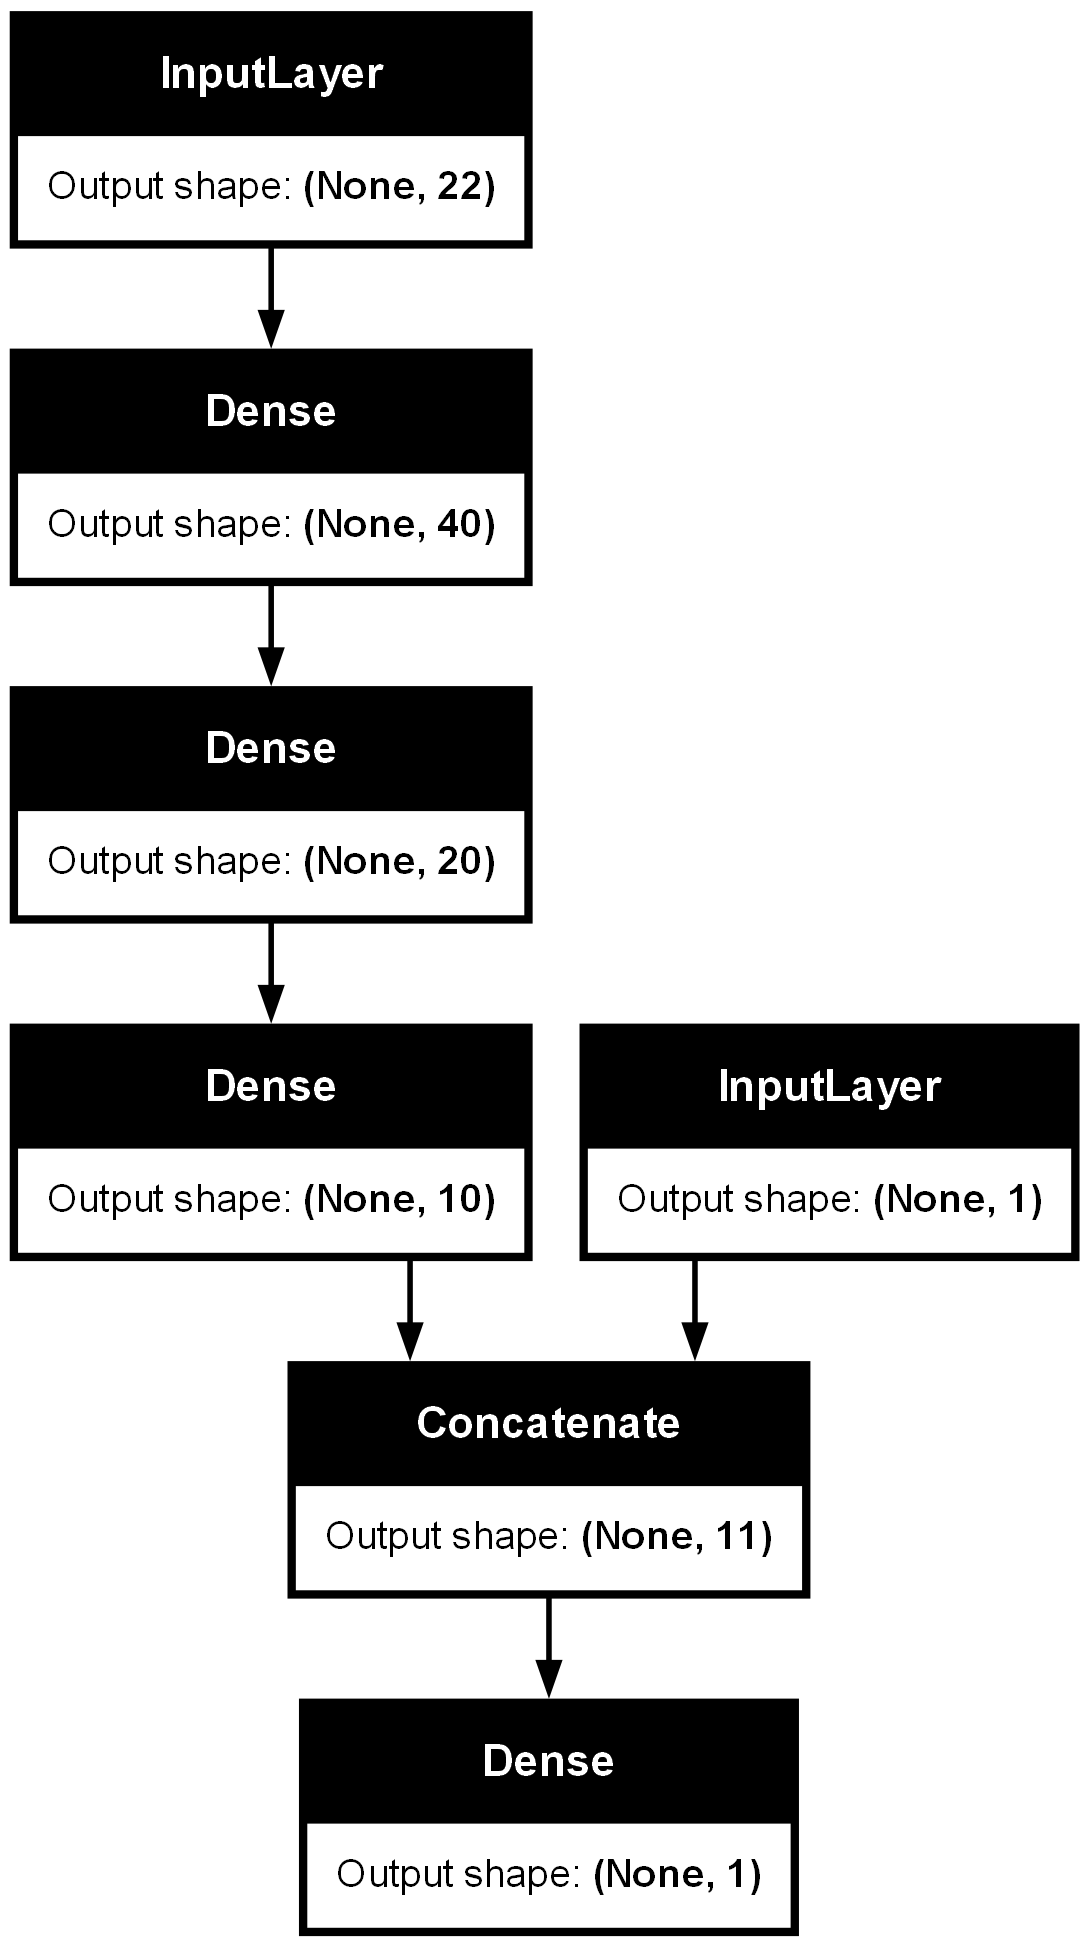

In [3]:
characteristic = characteristic_names[0]
V_used = X_used[characteristic]
W_used = X_used.drop([characteristic],axis=1)
param = np.array([40, 20, 10])

input_layer_1 = tf.keras.Input(shape=(1,), name="linear")

input_layer_2 = tf.keras.Input(shape=(W_used.shape[1],), name="nonlinear")
hidden_layer_1 = tf.keras.layers.Dense(param[0], activation='relu')(input_layer_2)
hidden_layer_2 = tf.keras.layers.Dense(param[1], activation='relu')(hidden_layer_1)
hidden_layer_3 = tf.keras.layers.Dense(param[2], activation='relu')(hidden_layer_2)

concat = tf.keras.layers.concatenate([input_layer_1, hidden_layer_3])

output_layer = tf.keras.layers.Dense(1, activation='linear')(concat)

model = tf.keras.Model(inputs=[input_layer_1,input_layer_2], outputs=output_layer)
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [4]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

batch_size = X_used.shape[0]
epochs = 1000
n_node = 5
model_tot = {}
for j, characteristic in enumerate(characteristic_names):
    print(characteristic)
    characteristic = characteristic_names[0]
    V_used = X_used[characteristic]
    W_used = X_used.drop([characteristic],axis=1)
    param = np.array([40, 20, 10])
    
    input_layer_1 = tf.keras.Input(shape=(1,), name="linear")
    input_layer_2 = tf.keras.Input(shape=(W_used.shape[1],), name="nonlinear")
    hidden_layer_1 = tf.keras.layers.Dense(param[0], activation='relu')(input_layer_2)
    hidden_layer_2 = tf.keras.layers.Dense(param[1], activation='relu')(hidden_layer_1)
    hidden_layer_3 = tf.keras.layers.Dense(param[2], activation='relu')(hidden_layer_2)
    concat = tf.keras.layers.concatenate([input_layer_1, hidden_layer_3])
    
    output_layer = tf.keras.layers.Dense(1, activation='linear')(concat)
    
    model = tf.keras.Model(inputs=[input_layer_1,input_layer_2], outputs=output_layer)
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2))

    model.fit({"linear": V_used, "nonlinear": W_used}, Y, batch_size=batch_size, epochs=epochs,verbose=0)
    model_tot[j] = model
    

zerotofive
sixtotwenty
grp
home_own
gender
isHHH
live_together
work
get_social_benefit
got_social_benefit
religion
marriage
health
exercise
smoke
alcohol


In [5]:
alpha_tot = {}
for j, characteristic in enumerate(characteristic_names):
    weights = model_tot[j].trainable_weights
    alpha_tot[characteristic] = weights[6][:][0].numpy()
display(pd.DataFrame(alpha_tot).T)

,0
zerotofive,0.118300
sixtotwenty,0.146616
grp,0.134347
home_own,0.093635
gender,0.134911
isHHH,0.153436
live_together,0.131360
work,0.112073
get_social_benefit,0.091954
got_social_benefit,0.094975


In [6]:
weights

[<KerasVariable shape=(22, 40), dtype=float32, path=dense_64/kernel>,
 <KerasVariable shape=(40,), dtype=float32, path=dense_64/bias>,
 <KerasVariable shape=(40, 20), dtype=float32, path=dense_65/kernel>,
 <KerasVariable shape=(20,), dtype=float32, path=dense_65/bias>,
 <KerasVariable shape=(20, 10), dtype=float32, path=dense_66/kernel>,
 <KerasVariable shape=(10,), dtype=float32, path=dense_66/bias>,
 <KerasVariable shape=(11, 1), dtype=float32, path=dense_67/kernel>,
 <KerasVariable shape=(1,), dtype=float32, path=dense_67/bias>]